In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report as cr, confusion_matrix as cf
import seaborn as sns
import matplotlib.pyplot as plt

## **Job Sponsorship Classification: Model Training & Prediction** ##

This project aims to develop a machine learning model to predict whether a job posting offers visa sponsorship based on its description. The process involves loading the processed dataset, extracting features using TF-IDF and n-grams, and training classification models such as Logistic Regression and Random Forest. Model performance will be evaluated using accuracy, precision, recall, and F1-score. Finally, the trained model will be used to predict sponsorship availability for new job descriptions, providing a practical tool for job seekers.

In [4]:
df = pd.read_csv("data/processed_job_data.csv")

In [20]:
def display_results(y_test, y_pred):
    classification_report = cr(y_test, y_pred, output_dict=True)
    classification_report_df = pd.DataFrame(classification_report).transpose()
    classification_report_df.index.name = "Category"
    classification_report_df = classification_report_df.rename(columns = {'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score', 'support': 'Support'})

    confusion_matrix = cf(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, index=['No Sponsorship', 'Sponsorship Provided', 'Uncertain'], columns=['Predicted: No Sponsorship', 'Predicted: Sponsorship Provided', 'Predicted: Uncertain'])
    
    fig, axes = plt.subplots(1, 2, figsize = (10, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax = axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    axes[1].axis('off')
    table = axes[1].table(
        cellText = classification_report_df.round(2).values,
        colLabels = classification_report_df.columns,
        rowLabels = classification_report_df.index,
        cellLoc = 'center',
        loc = 'center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    axes[1].set_title('Classification Report')

    plt.tight_layout()
    plt.show()


In [6]:
vectorizer = TfidfVectorizer( ngram_range=(1, 5))
X = vectorizer.fit_transform(df['processed_description'])
chi2_scores, _ = chi2(X, df['sponsorship_encoded'])
feature_names = vectorizer.get_feature_names_out()
selected_features = [feature_names[i] for i in chi2_scores.argsort()[-20:]]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, df['sponsorship_encoded'], test_size=0.2, random_state=42, stratify=df['sponsorship_encoded'])

In [12]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

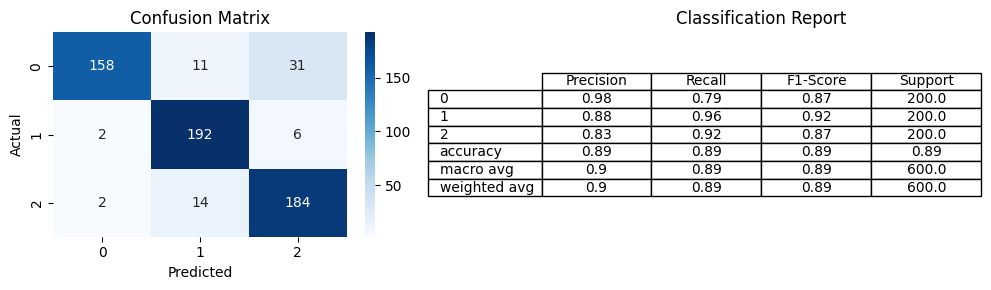

In [21]:
display_results(y_test, y_pred)

The model achieves an overall accuracy of 89%, performing well in classifying job postings into three categories. The confusion matrix shows that the model correctly identifies most jobs, but there is some misclassification, particularly between "No Sponsorship" and "Uncertain," suggesting overlap in language features. The classification report highlights strong precision (0.98) for Category 0 (No Sponsorship) and high recall (0.96) for Category 1 (Sponsorship Provided), indicating the model effectively detects sponsored jobs but sometimes misidentifies non-sponsored ones. Category 2 (Uncertain) has the lowest precision (0.83), showing that the model struggles slightly with ambiguity. While the F1-scores (0.87–0.92) remain strong, improvements could be made by refining features, adjusting classification thresholds, or handling class imbalances. Further fine-tuning could enhance the model’s ability to differentiate between uncertain and non-sponsored jobs.